# Importing the necessary Libraries

In [2]:
import pandas as pd
import itertools
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('drugsComTrain_raw.csv')

In [4]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [5]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [10]:
df_train = df[(df['condition'] == 'Birth Control') | (df['condition'] == 'Depression') | (df['condition'] == 'High Blood Pressure') | (df['condition'] == 'Diabetes, Type 2')]

In [12]:
df.shape

(161297, 7)

In [14]:
df_train.shape

(42732, 7)

In [16]:
X = df_train.drop(['uniqueID', 'drugName', 'rating', 'date', 'usefulCount'], axis = 1)

# EDA

In [19]:
X.condition.value_counts()

condition
Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: count, dtype: int64

In [21]:
X.head()

condition                                             review
2   Birth Control  "I used to take another oral contraceptive, wh...
3   Birth Control  "This is my first time using any form of birth...
9   Birth Control  "I had been on the pill for many years. When m...
11     Depression  "I have taken anti-depressants for years, with...
14  Birth Control  "Started Nexplanon 2 months ago because I have...

Segregating the database for analyzing individual condition

In [24]:
X_birth = X[(X['condition'] == 'Birth Control')]
X_dep = X[(X['condition'] == 'Depression')]
X_bp = X[(X['condition'] == 'High Blood Pressure')]
X_diab = X[(X['condition'] == 'Diabetes, Type 2')]

Text(0.5, 1.0, 'Word Cloud for Birth Control')

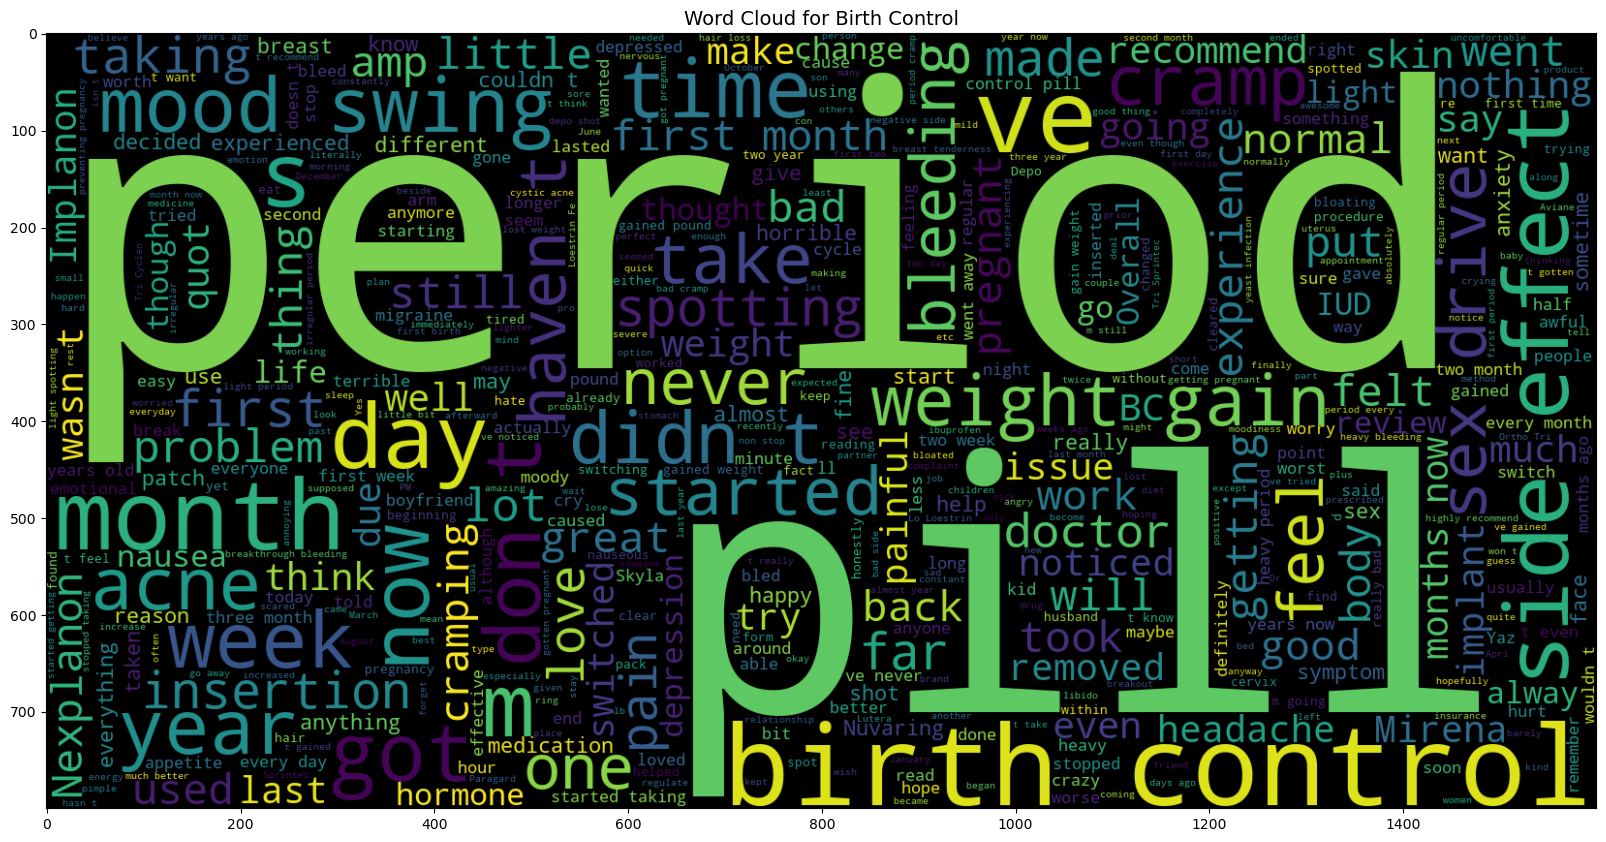

In [26]:
from wordcloud import WordCloud
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ". join(X_birth.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Birth Control', fontsize = 14)

Text(0.5, 1.0, 'Word Cloud for Depression')

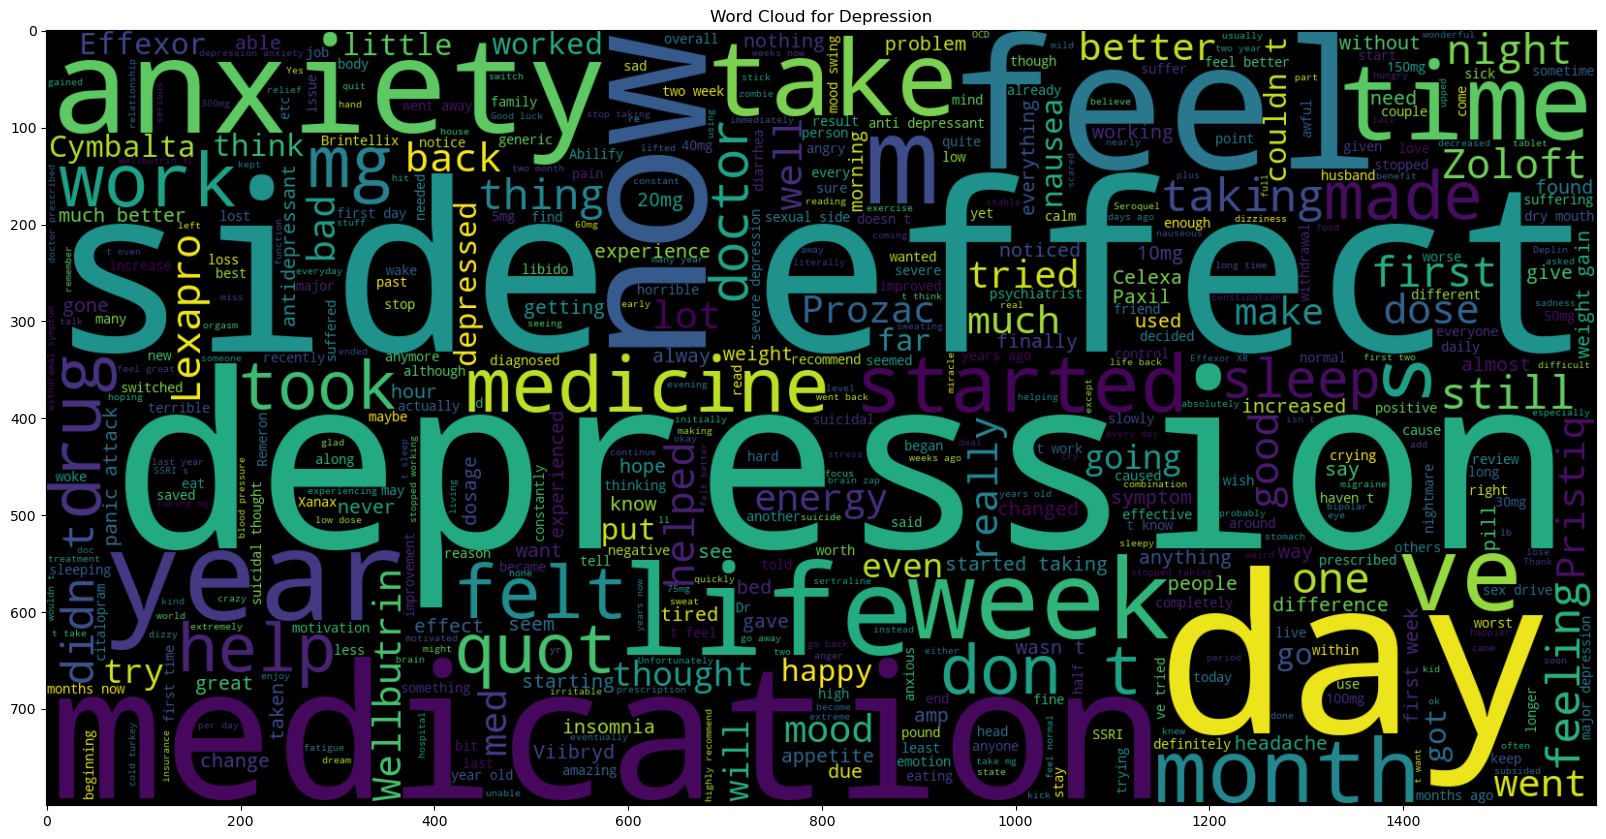

In [27]:
from wordcloud import WordCloud
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ". join(X_dep.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Depression')

Text(0.5, 1.0, 'Word Cloud for High Blood Pressure')

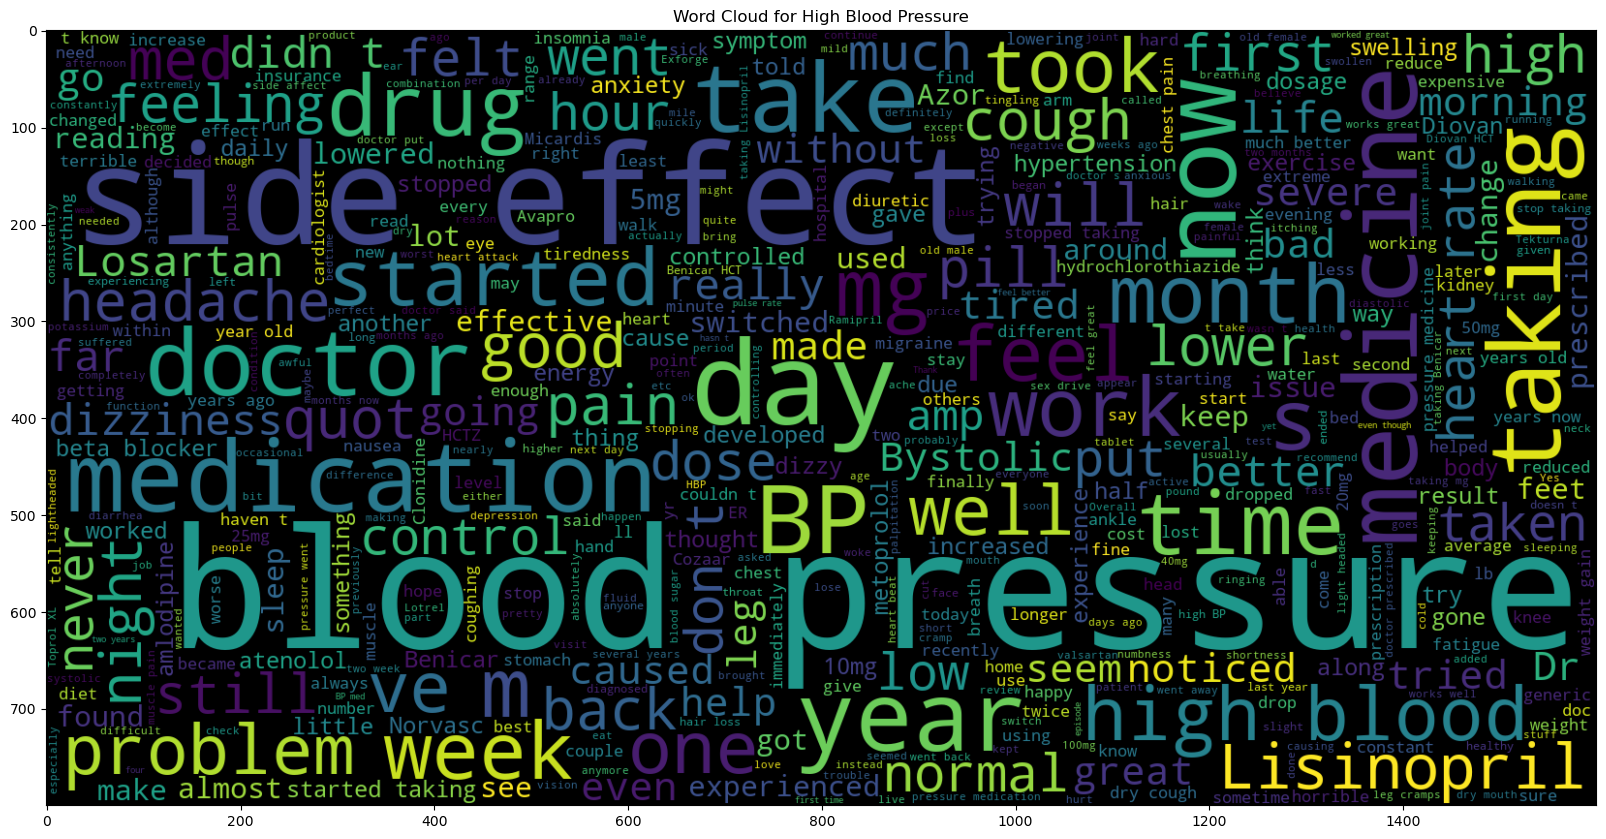

In [28]:
from wordcloud import WordCloud
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ". join(X_bp.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for High Blood Pressure')

Text(0.5, 1.0, 'Word Cloud for Diabetes, Type 2')

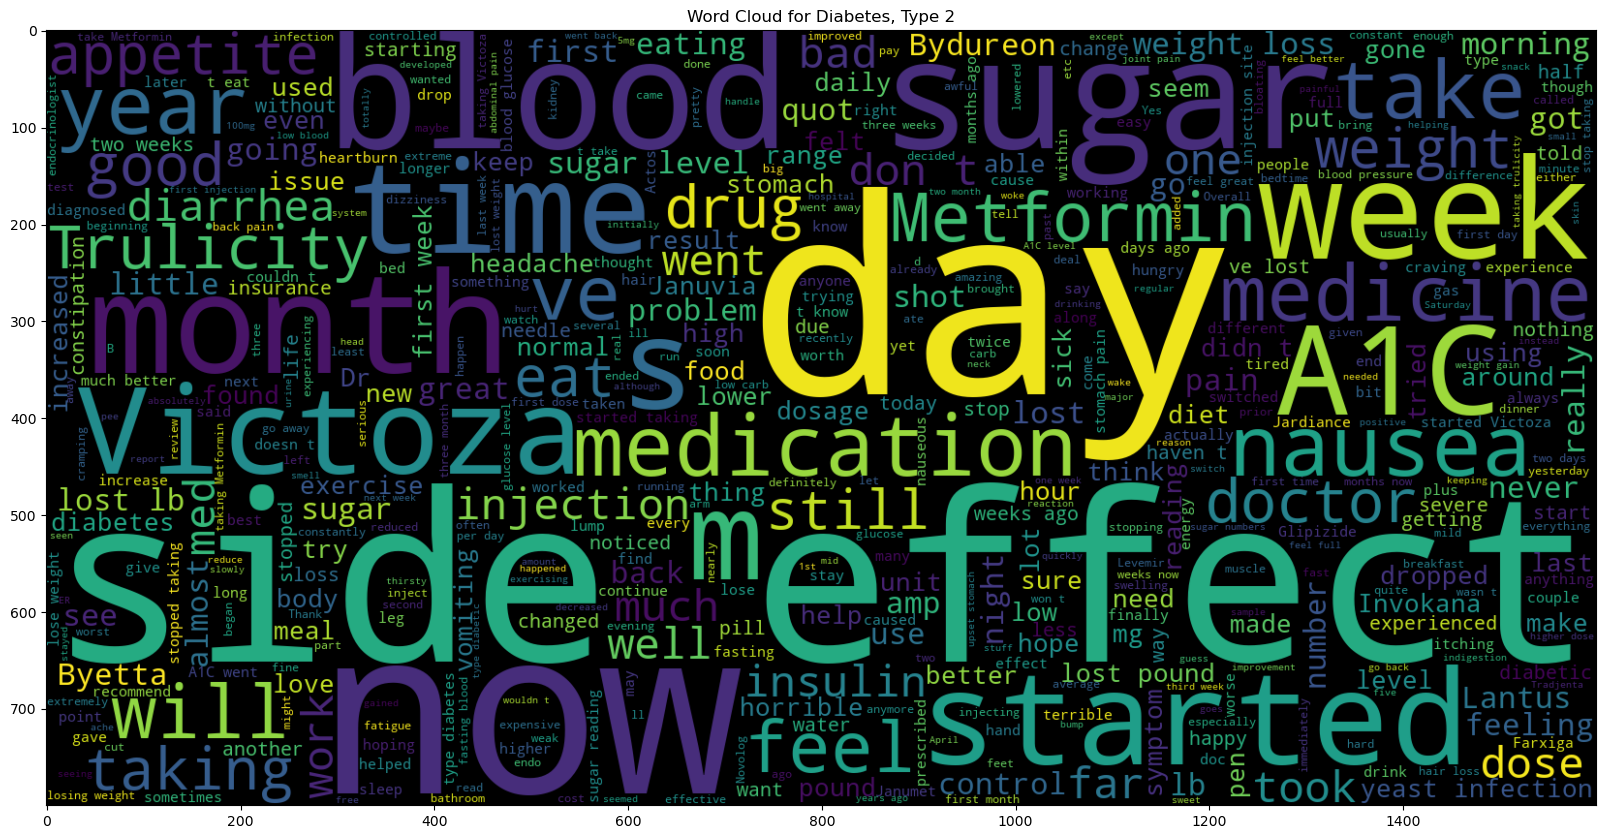

In [29]:
from wordcloud import WordCloud
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ". join(X_diab.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Diabetes, Type 2')

# Data Preprocessing

In [31]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [33]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [34]:
for i, col in enumerate(X.columns):
  X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [35]:
pd.set_option('max_colwidth', None)

In [36]:
X.head()

condition  \
2   Birth Control   
3   Birth Control   
9   Birth Control   
11     Depression   
14  Birth Control   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                review  
2                                  I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.  
3                                                                                                                                                                                                                                                                                                                                                       This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch  
9                                                      I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger.  
11                                                                                                                                                                                                                                                                                                                                  I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now an

Removing the stopwords

In [38]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('wordnet')
stop = stopwords.words('english')
stop

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

Lemmatization

In [40]:
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
  letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
  words = letters_only.lower().split()
  meaningful_words = [w for w in words if not w in stop]
  lemmatized_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
  return(" ".join(lemmatized_words))

In [41]:
X['review_clean'] = X['review'].apply(review_to_words)

C:\Users\yashk\AppData\Local\Temp\ipykernel_1984\2091144138.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [43]:
X.head()

condition  \
2   Birth Control   
3   Birth Control   
9   Birth Control   
11     Depression   
14  Birth Control   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                review  \
2                                  I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.   
3                                                                                                                                                                                                                                                                                                                                                       This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch   
9                                                      I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger.   
11                                                                                                                                                                                                                                                                                                                                  I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months no

# Creating Features and Target Variable

In [45]:
X_feat = X['review_clean']
y = X['condition']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, stratify = y, test_size = 0.2, random_state = 0)

In [47]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 0)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, without normalization')

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

# Bag of Words Model

In [50]:
count_vectorizer = CountVectorizer(stop_words = 'english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Machine Learning Model: Naive Bayes

accuracy:   0.970
Confusion Matrix, without normalization


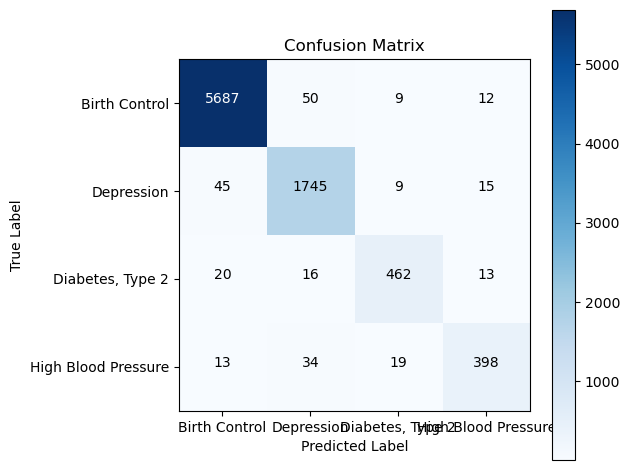

In [60]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

# Machine Learning Model: Passive Aggressive Classifier

accuracy:   0.977
Confusion Matrix, without normalization


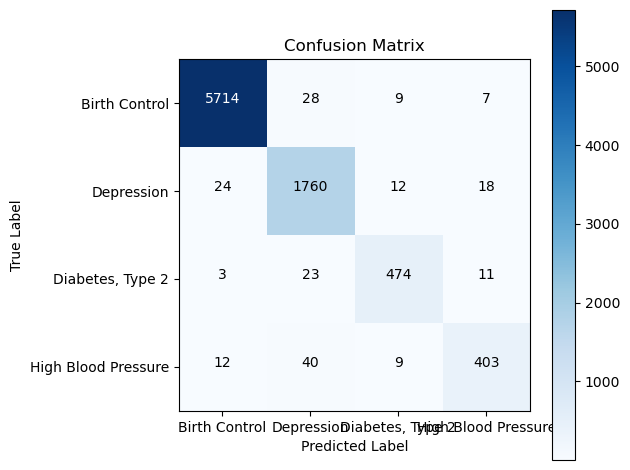

In [62]:
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

# TFIDF

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

# Machine Learning Model: Naive Bayes

accuracy =    0.922
Confusion Matrix, without normalization


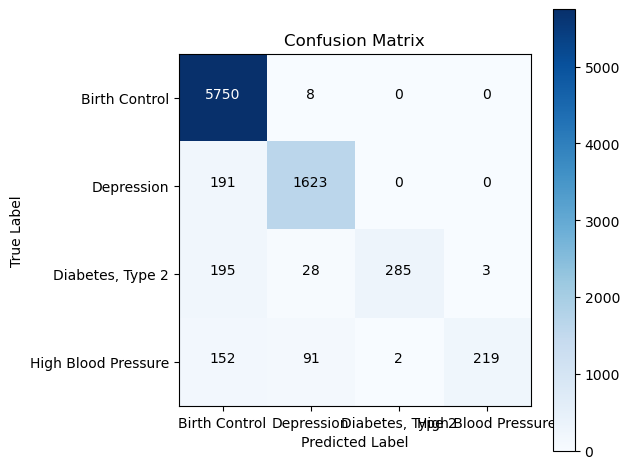

In [66]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy =    %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

# Machine Learning Model TFIDF

accuracy =    0.983
Confusion Matrix, without normalization


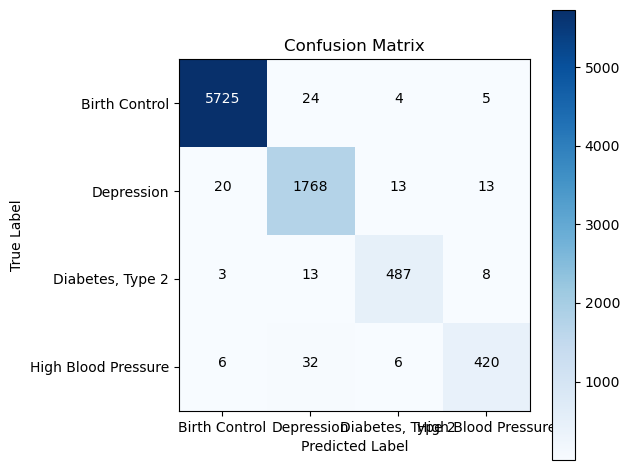

In [106]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy =    %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

# TFIDF: Bigrams

In [70]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2), max_df = 0.8)
tfidf_train_2 = tfidf_vectorizer_2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer_2.transform(X_test)

accuracy =    0.985
Confusion Matrix, without normalization


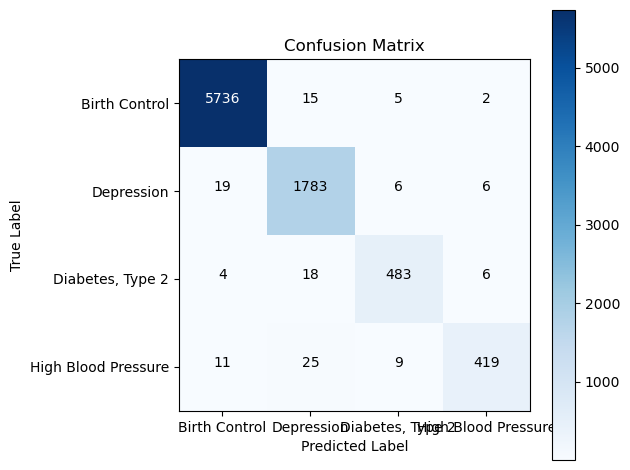

In [71]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy =    %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

# TFIDF: Trigrams

In [127]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 3), max_df = 0.8)
tfidf_train_3 = tfidf_vectorizer_3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer_3.transform(X_test)

accuracy =    0.986
Confusion Matrix, without normalization


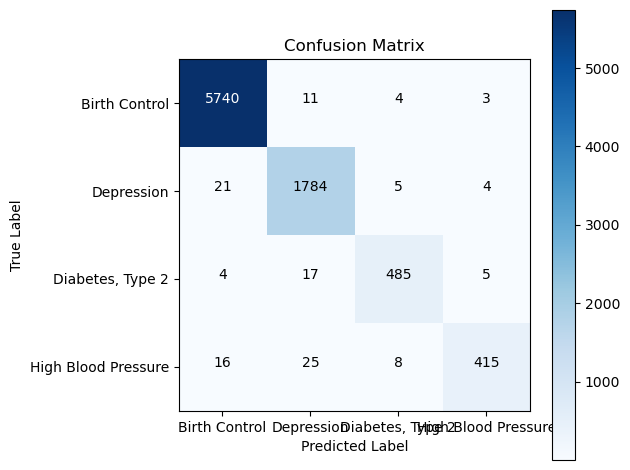

In [128]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy =    %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes = ['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

# Most Important Features

In [76]:
def most_important_features_for_class(vectorizer, classifier, classlabel, n = 10):
  labelid = list(classifier.classes_).index(classlabel)
  feature_names = vectorizer.get_feature_names_out()
  topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

  for coef, feat in topn:
    print(classlabel, feat, coef)

In [77]:
most_important_features_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')

Birth Control qualify 0.4949503886568103
Birth Control tricking 0.5349786606781123
Birth Control trickle 0.5349786606781123
Birth Control richer 0.5482941027518401
Birth Control pa 0.5817267009011515
Birth Control addon 0.5948352885398287
Birth Control aesthetician 0.6058908360396935
Birth Control tingliness 0.812624090847536
Birth Control commitment 1.1706268327789138
Birth Control freeness 7.079629671404039


In [83]:
most_important_features_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression sinequan 0.5264045026898747
Depression slave 0.528471796855853
Depression singapore 0.615300967548577
Depression developed 0.6586405583971732
Depression theme 0.676548806681765
Depression assertive 0.9018037551260715
Depression stwiching 1.0195441698265229
Depression signaling 1.090111357729668
Depression apo 1.1933989449076725
Depression alka 3.7995789569813017


In [85]:
most_important_features_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 fluctuating 0.37315126162810514
Diabetes, Type 2 aesthetician 0.4049545721729693
Diabetes, Type 2 varying 0.4121758048087427
Diabetes, Type 2 prohibitively 0.42539443105543867
Diabetes, Type 2 verbal 0.4476436218111451
Diabetes, Type 2 baseball 0.5178003043414258
Diabetes, Type 2 orthocept 0.6261059435934682
Diabetes, Type 2 forxiga 0.7433861996489304
Diabetes, Type 2 progressive 0.8290632621756716
Diabetes, Type 2 proaponolol 2.988391863701368


In [87]:
most_important_features_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

High Blood Pressure folding 0.5304356120741925
High Blood Pressure fatiqued 0.5643231413052509
High Blood Pressure fatter 0.5643231413052509
High Blood Pressure enforcement 0.5800918267863441
High Blood Pressure barr 0.6002572135129236
High Blood Pressure end 0.6306126520155702
High Blood Pressure encouraged 0.6338174932868504
High Blood Pressure fluctuating 0.696658893631017
High Blood Pressure shell 0.780489890112767
High Blood Pressure folic 1.0367634228366132


# Sample Predictions

In [93]:
X.tail()

condition  \
161273        Birth Control   
161278     Diabetes, Type 2   
161286           Depression   
161290  High Blood Pressure   
161291        Birth Control   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                review  \
161273  I have had the Nexplanon since Dec. 27, 2016 \r\r\nI got my first period at the end of January and it lasted about a month and a half. In March of 2017 I didn&#039;t bleed for close to three weeks and then started bleeding again March 28th and have been bleeding every since. I have gained about 13 lbs so far since getting the birth control. Although for now the weight gain isn&#039;t a deal breaker for me but the bleeding is..  I am trying to be very patient to see how my body adjusts to the implant. It has been three months so far and I have my fingers crossed that my cycle will go away for awhile.   
161278                                                                                                                                                                                                                                                                                                                                                                                                   I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I  am losing so much weight. No side effects yet. Miracle medicine for me   
161286                                                                                                                                                                                                                                                                                                                                                                                         This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am  and changing asap.   
161290                                                                                                                                                                                  I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.   
161291                                                                                                                                                                                                                          This would be my second month on Junel. I&#039;ve been on Birth Control for about 10 years now. I changed due to spotting and increased mood swings with my previous birth control. Since the switch I have had shorter periods about 2-3 days, but I have gained major weight and increased appetite. I switched up my regular exercise routine and still have not managed to drop the extra 7 lbs ;(   

                                                                                                                          

In [110]:
# Before testing run the Machine Learning Model TFIDF block

text = ["This would be my second month on Junel. I&#039;ve been on Birth Control for about 10 years now. I changed due to spotting and increased mood swings with my previous birth control. Since the switch I have had shorter periods about 2-3 days, but I have gained major weight and increased appetite. I switched up my regular exercise routine and still have not managed to drop the extra 7 lbs ;("]
test = tfidf_vectorizer.transform(text)
pred1 = pass_tf.predict(test)[0]
pred1

'Birth Control'

In [112]:
text = ["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.	"]
test = tfidf_vectorizer.transform(text)
pred1 = pass_tf.predict(test)[0]
pred1

'Depression'

In [114]:
text = ["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me	"]
test = tfidf_vectorizer.transform(text)
pred1 = pass_tf.predict(test)[0]
pred1

'Diabetes, Type 2'

In [116]:
text = ["This would be my second month on Junel. I&#039;ve been on Birth Control for about 10 years now. I changed due to spotting and increased mood swings with my previous birth control. Since the switch I have had shorter periods about 2-3 days, but I have gained major weight and increased appetite. I switched up my regular exercise routine and still have not managed to drop the extra 7 lbs ;(	"]
test = tfidf_vectorizer.transform(text)
pred1 = pass_tf.predict(test)[0]
pred1

'Birth Control'

# Testing and recommending Medicines

In [121]:
sentences = [
    "This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.	",
    "I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.	"
    "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me	"
             ]

In [123]:
def top_drugs_extractor(condition, df):
    top_drugs = (
        df[df['condition'] == condition]
        .groupby('drugName')
        .agg({'rating': 'mean', 'usefulCount': 'sum'})
        .sort_values(['rating', 'usefulCount'], ascending=False)
        .head(3)
        .index.tolist()
    )
    return top_drugs

In [131]:
tfidf_trigram = tfidf_vectorizer_3.transform(sentences)

predictions = pass_tf.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
  if label == "High Blood Pressure":
    target = "High Blood Pressure"
    top_drugs = top_drugs_extractor(label, df)
    print("Text: ", text, "\nCondition: ", target)
    print("Top 3 suggested Drugs:")
    print(top_drugs[0])
    print(top_drugs[1])
    print(top_drugs[2])
    print()
  elif label == "Depression":
    target = "Depression"
    top_drugs = top_drugs_extractor(label, df)
    print("Text: ", text, "\nCondition: ", target)
    print("Top 3 suggested Drugs:")
    print(top_drugs[0])
    print(top_drugs[1])
    print(top_drugs[2])
    print()
  elif label == "Diabetes, Type 2":
    target = "Diabetes, Type 2"
    top_drugs = top_drugs_extractor(label, df)
    print("Text: ", text, "\nCondition: ", target)
    print("Top 3 suggested Drugs:")
    print(top_drugs[0])
    print(top_drugs[1])
    print(top_drugs[2])
    print()
  else:
    target = "Birth Control"
    top_drugs = top_drugs_extractor(label, df)
    print("Text: ", text, "\nCondition: ", target)
    print("Top 3 suggested Drugs:")
    print(top_drugs[0])
    print(top_drugs[1])
    print(top_drugs[2])
    print()

Text:  This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.	 
Condition:  Depression
Top 3 suggested Drugs:
Norpramin
Xanax XR
Asendin

Text:  I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.	I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me	 
Condition:  High Blood Pr

In [139]:
import joblib

# Save trained vectorizer and model
joblib.dump(tfidf_vectorizer_3, 'tfidfvectorizer.pkl')
joblib.dump(pass_tf, 'passmodel.pkl')

['passmodel.pkl']

In [143]:
import joblib

# Load saved vectorizer and model
vectorizer = joblib.load('tfidfvectorizer.pkl')
model = joblib.load('passmodel.pkl')

# Example: Predict again with loaded model
example = ["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.	I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
predicted_condition = model.predict(vectorizer.transform(example))[0]
print("Predicted Condition:", predicted_condition)

top_drugs = top_drugs_extractor(predicted_condition, df)
print("Top 3 Recommended Drugs:")
for i, drug in enumerate(top_drugs, 1):
    print(f"{i}. {drug}")


Predicted Condition: High Blood Pressure
Top 3 Recommended Drugs:
1. Minipress
2. Plendil
3. Aldactazide
